 <a id="one"></a>
## 1. Importing Packages

In [17]:
# Ignore warnings
import warnings
warnings.simplefilter(action='ignore')

# Load Dependencies
import time
import pickle
import folium
import collections
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
import xgboost as xgb
import pygeohash as gh
import lightgbm as lgbm

#import folium.plugins as plugins

from math import sqrt
from sklearn import metrics
from sklearn.svm import SVR
#from folium.plugins import HeatMap
#from IPython.display import display
from catboost import CatBoostRegressor
from sklearn.feature_selection import RFE
from scipy.stats import boxcox, zscore
from statsmodels.formula.api import ols

from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso, Ridge, LinearRegression
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, PolynomialFeatures

# Display
%matplotlib inline
sns.set(font_scale=1)
sns.set_style("white")

<a id="two"></a>
## 2. Loading the Data

In [18]:
# Reading the data from the csv files
df_train = pd.read_csv('df_train.csv')
df_test = pd.read_csv('df_test.csv')

In [19]:
pd.set_option('display.max_columns', None)

In [20]:
df_train.drop('Unnamed: 0', axis=1, inplace=True)
df_test.drop('Unnamed: 0', axis=1, inplace=True)

In [21]:
df_train.head()

,time,Madrid_wind_speed,Valencia_wind_deg,Bilbao_rain_1h,Valencia_wind_speed,Seville_humidity,Madrid_humidity,Bilbao_clouds_all,Bilbao_wind_speed,Seville_clouds_all,Bilbao_wind_deg,Barcelona_wind_speed,Barcelona_wind_deg,Madrid_clouds_all,Seville_wind_speed,Barcelona_rain_1h,Seville_pressure,Seville_rain_1h,Bilbao_snow_3h,Barcelona_pressure,Seville_rain_3h,Madrid_rain_1h,Barcelona_rain_3h,Valencia_snow_3h,Madrid_weather_id,Barcelona_weather_id,Bilbao_pressure,Seville_weather_id,Valencia_pressure,Seville_temp_max,Madrid_pressure,Valencia_temp_max,Valencia_temp,Bilbao_weather_id,Seville_temp,Valencia_humidity,Valencia_temp_min,Barcelona_temp_max,Madrid_temp_max,Barcelona_temp,Bilbao_temp_min,Bilbao_temp,Barcelona_temp_min,Bilbao_temp_max,Seville_temp_min,Madrid_temp,Madrid_temp_min,load_shortfall_3h
0,2015-01-01 03:00:00,0.666667,level_5,0.0,0.666667,74.333333,64.000000,0.0,1.000000,0.0,223.333333,6.333333,42.666667,0.0,3.333333,0.0,sp25,0.0,0.0,1036.333333,0.0,0.0,0.0,0.0,800.0,800.0,1035.000000,800.0,1002.666667,274.254667,971.333333,269.888000,269.888000,800.0,274.254667,75.666667,269.888000,281.013000,265.938000,281.013000,269.338615,269.338615,281.013000,269.338615,274.254667,265.938000,265.938000,6715.666667
1,2015-01-01 06:00:00,0.333333,level_10,0.0,1.666667,78.333333,64.666667,0.0,1.000000,0.0,221.000000,4.000000,139.000000,0.0,3.333333,0.0,sp25,0.0,0.0,1037.333333,0.0,0.0,0.0,0.0,800.0,800.0,1035.666667,800.0,1004.333333,274.945000,972.666667,271.728333,271.728333,800.0,274.945000,71.000000,271.728333,280.561667,266.386667,280.561667,270.376000,270.376000,280.561667,270.376000,274.945000,266.386667,266.386667,4171.666667
2,2015-01-01 09:00:00,1.000000,level_9,0.0,1.000000,71.333333,64.333333,0.0,1.000000,0.0,214.333333,2.000000,326.000000,0.0,2.666667,0.0,sp25,0.0,0.0,1038.000000,0.0,0.0,0.0,0.0,800.0,800.0,1036.000000,800.0,1005.333333,278.792000,974.000000,278.008667,278.008667,800.0,278.792000,65.666667,278.008667,281.583667,272.708667,281.583667,275.027229,275.027229,281.583667,275.027229,278.792000,272.708667,272.708667,4274.666667
3,2015-01-01 12:00:00,1.000000,level_8,0.0,1.000000,65.333333,56.333333,0.0,1.000000,0.0,199.666667,2.333333,273.000000,0.0,4.000000,0.0,sp25,0.0,0.0,1037.000000,0.0,0.0,0.0,0.0,800.0,800.0,1036.000000,800.0,1009.000000,285.394000,994.666667,284.899552,284.899552,800.0,285.394000,54.000000,284.899552,283.434104,281.895219,283.434104,281.135063,281.135063,283.434104,281.135063,285.394000,281.895219,281.895219,5075.666667
4,2015-01-01 15:00:00,1.000000,level_7,0.0,1.000000,59.000000,57.000000,2.0,0.333333,0.0,185.000000,4.333333,260.000000,0.0,3.000000,0.0,sp25,0.0,0.0,1035.000000,0.0,0.0,0.0,0.0,800.0,800.0,1035.333333,800.0,NaN,285.513719,1035.333333,283.015115,283.015115,800.0,285.513719,58.333333,283.015115,284.213167,280.678437,284.213167,282.252063,282.252063,284.213167,282.252063,285.513719,280.678437,280.678437,6620.666667


In [22]:
df_test.head()

,time,Madrid_wind_speed,Valencia_wind_deg,Bilbao_rain_1h,Valencia_wind_speed,Seville_humidity,Madrid_humidity,Bilbao_clouds_all,Bilbao_wind_speed,Seville_clouds_all,Bilbao_wind_deg,Barcelona_wind_speed,Barcelona_wind_deg,Madrid_clouds_all,Seville_wind_speed,Barcelona_rain_1h,Seville_pressure,Seville_rain_1h,Bilbao_snow_3h,Barcelona_pressure,Seville_rain_3h,Madrid_rain_1h,Barcelona_rain_3h,Valencia_snow_3h,Madrid_weather_id,Barcelona_weather_id,Bilbao_pressure,Seville_weather_id,Valencia_pressure,Seville_temp_max,Madrid_pressure,Valencia_temp_max,Valencia_temp,Bilbao_weather_id,Seville_temp,Valencia_humidity,Valencia_temp_min,Barcelona_temp_max,Madrid_temp_max,Barcelona_temp,Bilbao_temp_min,Bilbao_temp,Barcelona_temp_min,Bilbao_temp_max,Seville_temp_min,Madrid_temp,Madrid_temp_min
0,2018-01-01 00:00:00,5.000000,level_8,0.0,5.000000,87.000000,71.333333,20.000000,3.000000,0.000000,193.333333,4.000000,176.666667,0.0,1.000000,0.0,sp25,0.0,0,1017.333333,0.0,0.0,0.0,0,800.0,800.000000,1025.666667,800.000000,NaN,284.483333,1030.000000,287.483333,287.483333,801.000000,283.673333,46.333333,287.483333,287.816667,280.816667,287.356667,276.150000,280.380000,286.816667,285.150000,283.150000,279.866667,279.150000
1,2018-01-01 03:00:00,4.666667,level_8,0.0,5.333333,89.000000,78.000000,0.000000,3.666667,0.000000,143.333333,4.666667,266.666667,0.0,0.666667,0.0,sp25,0.0,0,1020.333333,0.0,0.0,0.0,0,800.0,800.333333,1026.666667,800.000000,NaN,282.483333,1030.333333,284.150000,284.150000,721.000000,281.673333,53.666667,284.150000,284.816667,280.483333,284.190000,277.816667,281.010000,283.483333,284.150000,281.150000,279.193333,278.150000
2,2018-01-01 06:00:00,2.333333,level_7,0.0,5.000000,89.000000,89.666667,0.000000,2.333333,6.666667,130.000000,4.000000,263.333333,0.0,0.666667,0.0,sp25,0.0,0,1023.000000,0.0,0.0,0.0,0,800.0,800.000000,1025.333333,800.333333,NaN,280.816667,1030.666667,282.816667,282.816667,800.000000,280.613333,42.000000,282.816667,284.483333,276.483333,283.150000,276.816667,279.196667,281.816667,282.150000,280.483333,276.340000,276.150000
3,2018-01-01 09:00:00,2.666667,level_7,0.0,5.333333,93.333333,82.666667,26.666667,5.666667,6.666667,196.666667,2.333333,86.666667,0.0,1.333333,0.0,sp25,0.0,0,1025.666667,0.0,0.0,0.0,0,800.0,800.000000,1025.000000,800.333333,NaN,281.150000,1032.333333,283.483333,283.483333,801.333333,279.936667,45.000000,283.483333,284.150000,277.150000,283.190000,279.150000,281.740000,282.150000,284.483333,279.150000,275.953333,274.483333
4,2018-01-01 12:00:00,4.000000,level_7,0.0,8.666667,65.333333,64.000000,26.666667,10.666667,0.000000,233.333333,4.666667,283.333333,0.0,1.000000,0.0,sp25,0.0,0,1026.000000,0.0,0.0,0.0,0,800.0,800.333333,1022.333333,800.000000,NaN,287.150000,1032.333333,287.150000,287.150000,801.333333,285.570000,41.000000,287.150000,287.483333,281.150000,286.816667,281.816667,284.116667,286.150000,286.816667,284.483333,280.686667,280.150000


#### Dataframes overview

In [23]:
# training dataset 
df_train.shape

(8763, 48)

In [24]:
# testing dataset
df_test.shape

(2920, 47)

In [25]:
# datatypes of the training dataframes
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8763 entries, 0 to 8762
Data columns (total 48 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   time                  8763 non-null   object 
 1   Madrid_wind_speed     8763 non-null   float64
 2   Valencia_wind_deg     8763 non-null   object 
 3   Bilbao_rain_1h        8763 non-null   float64
 4   Valencia_wind_speed   8763 non-null   float64
 5   Seville_humidity      8763 non-null   float64
 6   Madrid_humidity       8763 non-null   float64
 7   Bilbao_clouds_all     8763 non-null   float64
 8   Bilbao_wind_speed     8763 non-null   float64
 9   Seville_clouds_all    8763 non-null   float64
 10  Bilbao_wind_deg       8763 non-null   float64
 11  Barcelona_wind_speed  8763 non-null   float64
 12  Barcelona_wind_deg    8763 non-null   float64
 13  Madrid_clouds_all     8763 non-null   float64
 14  Seville_wind_speed    8763 non-null   float64
 15  Barcelona_rain_1h    

In [26]:
# datatypes of the testing dataframes
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2920 entries, 0 to 2919
Data columns (total 47 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   time                  2920 non-null   object 
 1   Madrid_wind_speed     2920 non-null   float64
 2   Valencia_wind_deg     2920 non-null   object 
 3   Bilbao_rain_1h        2920 non-null   float64
 4   Valencia_wind_speed   2920 non-null   float64
 5   Seville_humidity      2920 non-null   float64
 6   Madrid_humidity       2920 non-null   float64
 7   Bilbao_clouds_all     2920 non-null   float64
 8   Bilbao_wind_speed     2920 non-null   float64
 9   Seville_clouds_all    2920 non-null   float64
 10  Bilbao_wind_deg       2920 non-null   float64
 11  Barcelona_wind_speed  2920 non-null   float64
 12  Barcelona_wind_deg    2920 non-null   float64
 13  Madrid_clouds_all     2920 non-null   float64
 14  Seville_wind_speed    2920 non-null   float64
 15  Barcelona_rain_1h    

In [27]:
# missing data on the dataframes on training dataset
df_train.isnull().sum()

time                       0
Madrid_wind_speed          0
Valencia_wind_deg          0
Bilbao_rain_1h             0
Valencia_wind_speed        0
Seville_humidity           0
Madrid_humidity            0
Bilbao_clouds_all          0
Bilbao_wind_speed          0
Seville_clouds_all         0
Bilbao_wind_deg            0
Barcelona_wind_speed       0
Barcelona_wind_deg         0
Madrid_clouds_all          0
Seville_wind_speed         0
Barcelona_rain_1h          0
Seville_pressure           0
Seville_rain_1h            0
Bilbao_snow_3h             0
Barcelona_pressure         0
Seville_rain_3h            0
Madrid_rain_1h             0
Barcelona_rain_3h          0
Valencia_snow_3h           0
Madrid_weather_id          0
Barcelona_weather_id       0
Bilbao_pressure            0
Seville_weather_id         0
Valencia_pressure       2068
Seville_temp_max           0
Madrid_pressure            0
Valencia_temp_max          0
Valencia_temp              0
Bilbao_weather_id          0
Seville_temp  

In [28]:
# missing data on the dataframes on testing dataset
df_test.isnull().sum()

time                      0
Madrid_wind_speed         0
Valencia_wind_deg         0
Bilbao_rain_1h            0
Valencia_wind_speed       0
Seville_humidity          0
Madrid_humidity           0
Bilbao_clouds_all         0
Bilbao_wind_speed         0
Seville_clouds_all        0
Bilbao_wind_deg           0
Barcelona_wind_speed      0
Barcelona_wind_deg        0
Madrid_clouds_all         0
Seville_wind_speed        0
Barcelona_rain_1h         0
Seville_pressure          0
Seville_rain_1h           0
Bilbao_snow_3h            0
Barcelona_pressure        0
Seville_rain_3h           0
Madrid_rain_1h            0
Barcelona_rain_3h         0
Valencia_snow_3h          0
Madrid_weather_id         0
Barcelona_weather_id      0
Bilbao_pressure           0
Seville_weather_id        0
Valencia_pressure       454
Seville_temp_max          0
Madrid_pressure           0
Valencia_temp_max         0
Valencia_temp             0
Bilbao_weather_id         0
Seville_temp              0
Valencia_humidity   

In [29]:
# summary statistics
df_train.describe()

,Madrid_wind_speed,Bilbao_rain_1h,Valencia_wind_speed,Seville_humidity,Madrid_humidity,Bilbao_clouds_all,Bilbao_wind_speed,Seville_clouds_all,Bilbao_wind_deg,Barcelona_wind_speed,Barcelona_wind_deg,Madrid_clouds_all,Seville_wind_speed,Barcelona_rain_1h,Seville_rain_1h,Bilbao_snow_3h,Barcelona_pressure,Seville_rain_3h,Madrid_rain_1h,Barcelona_rain_3h,Valencia_snow_3h,Madrid_weather_id,Barcelona_weather_id,Bilbao_pressure,Seville_weather_id,Valencia_pressure,Seville_temp_max,Madrid_pressure,Valencia_temp_max,Valencia_temp,Bilbao_weather_id,Seville_temp,Valencia_humidity,Valencia_temp_min,Barcelona_temp_max,Madrid_temp_max,Barcelona_temp,Bilbao_temp_min,Bilbao_temp,Barcelona_temp_min,Bilbao_temp_max,Seville_temp_min,Madrid_temp,Madrid_temp_min,load_shortfall_3h
count,8763.000000,8763.000000,8763.000000,8763.000000,8763.000000,8763.000000,8763.000000,8763.000000,8763.000000,8763.000000,8763.000000,8763.000000,8763.000000,8763.000000,8763.000000,8763.000000,8.763000e+03,8763.000000,8763.000000,8763.000000,8763.000000,8763.000000,8763.000000,8763.000000,8763.000000,6695.000000,8763.000000,8763.000000,8763.000000,8763.000000,8763.000000,8763.000000,8763.000000,8763.000000,8763.000000,8763.000000,8763.000000,8763.000000,8763.000000,8763.000000,8763.000000,8763.000000,8763.000000,8763.000000,8763.000000
mean,2.425729,0.135753,2.586272,62.658793,57.414717,43.469132,1.850356,13.714748,158.957511,2.870497,190.544848,19.473392,2.425045,0.128906,0.039439,0.031912,1.377965e+03,0.000243,0.037818,0.000439,0.000205,773.527594,765.979687,1017.739549,774.658818,1012.051407,297.479527,1010.316920,291.337233,290.592152,724.722362,293.978903,65.247727,289.867648,291.157644,289.540309,289.855459,285.017973,286.422929,288.447422,287.966027,291.633356,288.419439,287.202203,10673.857612
std,1.850371,0.374901,2.411190,22.621226,24.335396,32.551044,1.695888,24.272482,102.056299,1.792197,89.077337,28.053660,1.672895,0.634730,0.175857,0.557264,1.407314e+04,0.003660,0.152639,0.003994,0.011866,77.313315,88.142235,10.046124,71.940009,9.506214,8.875812,22.198555,7.565692,7.162274,115.846537,7.920986,19.262322,6.907402,7.273538,9.752047,6.528111,6.705672,6.818682,6.102593,7.105590,8.178220,9.346796,9.206237,5218.046404
min,0.000000,0.000000,0.000000,8.333333,6.333333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.706667e+02,0.000000,0.000000,0.000000,0.000000,211.000000,200.666667,971.333333,200.000000,972.666667,272.063000,927.666667,269.888000,269.888000,207.333333,272.063000,10.333333,269.888000,272.150000,264.983333,270.816667,264.483333,267.483333,269.483333,269.063000,270.150000,264.983333,264.983333,-6618.000000
25%,1.000000,0.000000,1.000000,44.333333,36.333333,10.000000,0.666667,0.000000,73.333333,1.666667,118.166667,0.000000,1.000000,0.000000,0.000000,0.000000,1.014000e+03,0.000000,0.000000,0.000000,0.000000,800.000000,800.000000,1013.000000,800.000000,1010.333333,291.312750,1012.333333,285.550167,285.150000,700.333333,288.282917,51.333333,284.783333,285.483333,282.150000,284.973443,280.085167,281.374167,284.150000,282.836776,285.816667,281.404281,280.299167,7390.333333
50%,2.000000,0.000000,1.666667,65.666667,58.000000,45.000000,1.000000,0.000000,147.000000,2.666667,200.000000,0.000000,2.000000,0.000000,0.000000,0.000000,1.018000e+03,0.000000,0.000000,0.000000,0.000000,800.000000,800.333333,1019.000000,800.000000,1015.000000,297.101667,1017.333333,291.037000,290.176667,800.000000,293.323333,67.000000,289.550000,290.150000,288.116177,289.416667,284.816667,286.158333,288.150000,287.630000,290.816667,287.053333,286.083333,11114.666667
75%,3.333333,0.100000,3.666667,82.000000,78.666667,75.000000,2.666667,20.000000,234.000000,4.000000,260.000000,33.333333,3.333333,0.000000,0.000000,0.000000,1.022000e+03,0.000000,0.000000,0.000000,0.000000,800.666667,801.000000,1024.000000,800.000000,1018.000000,304.150000,1022.000000,297.248333,296.056667,801.666667,299.620333,81.333333,294.820000,296.855000,296.816667,

In [30]:
# summary statistics
df_test.describe()

,Madrid_wind_speed,Bilbao_rain_1h,Valencia_wind_speed,Seville_humidity,Madrid_humidity,Bilbao_clouds_all,Bilbao_wind_speed,Seville_clouds_all,Bilbao_wind_deg,Barcelona_wind_speed,Barcelona_wind_deg,Madrid_clouds_all,Seville_wind_speed,Barcelona_rain_1h,Seville_rain_1h,Bilbao_snow_3h,Barcelona_pressure,Seville_rain_3h,Madrid_rain_1h,Barcelona_rain_3h,Valencia_snow_3h,Madrid_weather_id,Barcelona_weather_id,Bilbao_pressure,Seville_weather_id,Valencia_pressure,Seville_temp_max,Madrid_pressure,Valencia_temp_max,Valencia_temp,Bilbao_weather_id,Seville_temp,Valencia_humidity,Valencia_temp_min,Barcelona_temp_max,Madrid_temp_max,Barcelona_temp,Bilbao_temp_min,Bilbao_temp,Barcelona_temp_min,Bilbao_temp_max,Seville_temp_min,Madrid_temp,Madrid_temp_min
count,2920.000000,2920.000000,2920.000000,2920.000000,2920.000000,2920.000000,2920.000000,2920.000000,2920.000000,2920.000000,2920.000000,2920.000000,2920.000000,2920.000000,2920.000000,2920.0,2920.000000,2920.000000,2920.000000,2920.000000,2920.0,2920.000000,2920.000000,2920.000000,2920.000000,2466.000000,2920.000000,2920.000000,2920.000000,2920.000000,2920.000000,2920.000000,2920.000000,2920.000000,2920.000000,2920.000000,2920.000000,2920.000000,2920.000000,2920.000000,2920.000000,2920.000000,2920.000000,2920.000000
mean,2.457820,0.067517,3.012785,67.123516,62.644463,43.355422,2.283562,15.477283,162.643836,2.518094,178.979452,24.255822,2.657192,0.047397,0.046164,0.0,1015.317123,0.000001,0.059863,0.000006,0.0,758.820101,760.473307,1016.709132,772.226294,1013.148351,291.589360,1016.240411,291.439216,291.377796,737.039079,290.746255,64.623916,291.317184,290.695462,288.888393,289.911289,284.920684,286.522375,289.124971,288.483641,290.152431,287.869763,286.618130
std,1.774838,0.153381,1.996340,20.611292,24.138393,30.486298,1.654787,25.289197,97.749873,1.625507,86.976503,29.430257,1.788870,0.162474,0.193432,0.0,7.021445,0.000074,0.193218,0.000217,0.0,93.536025,98.009846,8.773784,75.727539,6.528997,7.521748,9.624074,7.055448,7.113243,106.129916,7.738131,18.355766,7.176955,7.113599,9.089699,7.119411,6.803424,6.492355,7.168049,6.221324,7.906915,8.977511,8.733163
min,0.000000,0.000000,0.000000,11.666667,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,988.333333,0.000000,0.000000,0.000000,0.0,262.500000,207.333333,975.000000,259.500000,973.000000,273.816667,943.000000,273.816667,273.816667,207.666667,272.350000,13.000000,273.816667,273.816667,269.816667,272.650000,266.483333,268.120000,271.483333,270.138667,271.150000,268.713333,267.816667
25%,1.333333,0.000000,1.666667,52.000000,43.000000,13.333333,1.000000,0.000000,86.666667,1.333333,113.333333,0.000000,1.333333,0.000000,0.000000,0.0,1012.000000,0.000000,0.000000,0.000000,0.0,800.000000,800.000000,1013.333333,800.000000,1010.666667,286.150000,1013.666667,286.150000,285.816667,702.000000,285.356667,52.000000,285.816667,284.816667,281.483333,284.307500,280.150000,281.778333,283.483333,284.150000,284.483333,280.816667,279.816667
50%,2.000000,0.000000,2.333333,70.333333,63.000000,45.000000,1.666667,0.000000,140.000000,2.000000,176.666667,11.333333,2.333333,0.000000,0.000000,0.0,1016.000000,0.000000,0.000000,0.000000,0.0,800.000000,800.000000,1017.666667,800.000000,1014.666667,290.483333,1017.333333,291.150000,291.150000,800.000000,289.540000,65.000000,291.150000,290.150000,287.483333,289.483333,284.483333,286.265000,288.816667,288.483333,289.150000,286.396667,285.483333
75%,3.333333,0.000000,4.000000,85.000000,84.000000,75.000000,3.333333,20.000000,233.333333,3.666667,253.333333,40.000000,3.666667,0.000000,0.000000,0.0,1019.333333,0.000000,0.000000,0.000000,0.0,800.666667,801.000000,1022.000000,800.333333,1017.666667,296.483333,1021.333333,297.150000,297.150000,802.000000,295.674167,79.333333,297.150000,296.483333,295.483333,295.816667,289.816667,291.119167,295.150000,292.816667,295.150000,294.452500,293.150000
max,13.333333,1.600000,14.333333,100.000000,100.000000,97.333333,10.666667,93.333333,36

In [31]:
# extracting data from the time column in the training dataframe
df_train['day'] = pd.to_datetime(df_train['time']).dt.day
df_train['month'] = pd.to_datetime(df_train['time']).dt.month
df_train['year'] = pd.to_datetime(df_train['time']).dt.year
df_train['hour'] = pd.to_datetime(df_train['time'].astype(str)).dt.hour.astype(float)

# extracting data from the time column in the test dataframe
df_test['day'] = pd.to_datetime(df_test['time']).dt.day
df_test['month'] = pd.to_datetime(df_test['time']).dt.month
df_test['year'] = pd.to_datetime(df_test['time']).dt.year
df_test['hour'] = pd.to_datetime(df_test['time'].astype(str)).dt.hour.astype(float)

In [32]:
# the Valencia wind degree is of type object so i am currently dropping it.
df_train.drop('Valencia_wind_deg', axis =1, inplace = True)
df_test.drop('Valencia_wind_deg', axis =1, inplace = True)

# dropping the time column since we have extracted the necessary values from it
df_train.drop('time', axis=1, inplace = True )


# extracting the values so we can have values in that column
df_train['Seville_pressure'] = df_train['Seville_pressure'].str.extract('(\d+)').astype(float)
df_test['Seville_pressure'] = df_test['Seville_pressure'].str.extract('(\d+)').astype(float)

In [33]:
df_train.head()

,Madrid_wind_speed,Bilbao_rain_1h,Valencia_wind_speed,Seville_humidity,Madrid_humidity,Bilbao_clouds_all,Bilbao_wind_speed,Seville_clouds_all,Bilbao_wind_deg,Barcelona_wind_speed,Barcelona_wind_deg,Madrid_clouds_all,Seville_wind_speed,Barcelona_rain_1h,Seville_pressure,Seville_rain_1h,Bilbao_snow_3h,Barcelona_pressure,Seville_rain_3h,Madrid_rain_1h,Barcelona_rain_3h,Valencia_snow_3h,Madrid_weather_id,Barcelona_weather_id,Bilbao_pressure,Seville_weather_id,Valencia_pressure,Seville_temp_max,Madrid_pressure,Valencia_temp_max,Valencia_temp,Bilbao_weather_id,Seville_temp,Valencia_humidity,Valencia_temp_min,Barcelona_temp_max,Madrid_temp_max,Barcelona_temp,Bilbao_temp_min,Bilbao_temp,Barcelona_temp_min,Bilbao_temp_max,Seville_temp_min,Madrid_temp,Madrid_temp_min,load_shortfall_3h,day,month,year,hour
0,0.666667,0.0,0.666667,74.333333,64.000000,0.0,1.000000,0.0,223.333333,6.333333,42.666667,0.0,3.333333,0.0,25.0,0.0,0.0,1036.333333,0.0,0.0,0.0,0.0,800.0,800.0,1035.000000,800.0,1002.666667,274.254667,971.333333,269.888000,269.888000,800.0,274.254667,75.666667,269.888000,281.013000,265.938000,281.013000,269.338615,269.338615,281.013000,269.338615,274.254667,265.938000,265.938000,6715.666667,1,1,2015,3.0
1,0.333333,0.0,1.666667,78.333333,64.666667,0.0,1.000000,0.0,221.000000,4.000000,139.000000,0.0,3.333333,0.0,25.0,0.0,0.0,1037.333333,0.0,0.0,0.0,0.0,800.0,800.0,1035.666667,800.0,1004.333333,274.945000,972.666667,271.728333,271.728333,800.0,274.945000,71.000000,271.728333,280.561667,266.386667,280.561667,270.376000,270.376000,280.561667,270.376000,274.945000,266.386667,266.386667,4171.666667,1,1,2015,6.0
2,1.000000,0.0,1.000000,71.333333,64.333333,0.0,1.000000,0.0,214.333333,2.000000,326.000000,0.0,2.666667,0.0,25.0,0.0,0.0,1038.000000,0.0,0.0,0.0,0.0,800.0,800.0,1036.000000,800.0,1005.333333,278.792000,974.000000,278.008667,278.008667,800.0,278.792000,65.666667,278.008667,281.583667,272.708667,281.583667,275.027229,275.027229,281.583667,275.027229,278.792000,272.708667,272.708667,4274.666667,1,1,2015,9.0
3,1.000000,0.0,1.000000,65.333333,56.333333,0.0,1.000000,0.0,199.666667,2.333333,273.000000,0.0,4.000000,0.0,25.0,0.0,0.0,1037.000000,0.0,0.0,0.0,0.0,800.0,800.0,1036.000000,800.0,1009.000000,285.394000,994.666667,284.899552,284.899552,800.0,285.394000,54.000000,284.899552,283.434104,281.895219,283.434104,281.135063,281.135063,283.434104,281.135063,285.394000,281.895219,281.895219,5075.666667,1,1,2015,12.0
4,1.000000,0.0,1.000000,59.000000,57.000000,2.0,0.333333,0.0,185.000000,4.333333,260.000000,0.0,3.000000,0.0,25.0,0.0,0.0,1035.000000,0.0,0.0,0.0,0.0,800.0,800.0,1035.333333,800.0,NaN,285.513719,1035.333333,283.015115,283.015115,800.0,285.513719,58.333333,283.015115,284.213167,280.678437,284.213167,282.252063,282.252063,284.213167,282.252063,285.513719,280.678437,280.678437,6620.666667,1,1,2015,15.0


In [34]:
# collecting all temperature columns
temp_columns = list(df_train.columns[df_train.columns.str.contains('temp')])

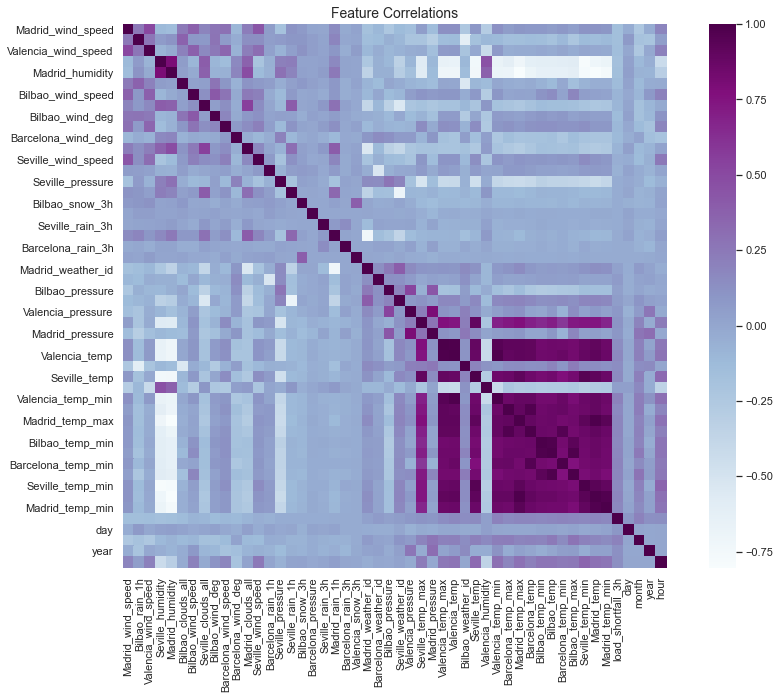

In [35]:
fig,axis = plt.subplots(figsize=(15, 10))
sns.heatmap(df_train.corr(), square=True, cmap='BuPu')
plt.title('Feature Correlations',fontsize=14)

plt.show()

In [36]:
# combining all the temperature columns
df_train['Spain_Avg_temp']=df_train[df_train.columns[df_train.columns.str.contains('temp')]].mean(axis =1)
df_test['Spain_Avg_temp']=df_test[df_test.columns[df_test.columns.str.contains('temp')]].mean(axis =1)

# combining the seville and Madrid humidity
df_train['sev_mad_val_humidity']=df_train[['Seville_humidity','Madrid_humidity','Valencia_humidity']].mean(axis =1)
df_test['sev_mad_val_humidity']=df_test[['Seville_humidity','Madrid_humidity','Valencia_humidity']].mean(axis =1)

# Dealing with the missing values for both train and test dataset
df_train.fillna(np.mean(df_train.Valencia_pressure),inplace=True)

df_test.fillna(np.mean(df_test.Valencia_pressure),inplace=True)


# combining the pressure columns
df_train['mad_val_bil_pressure']= df_train[['Valencia_pressure','Madrid_pressure','Bilbao_pressure']].mean(axis = 1)
df_test['mad_val_bil_pressure']= df_test[['Valencia_pressure','Madrid_pressure','Bilbao_pressure']].mean(axis = 1)

# combining the columns
df_train['Madrid'] = df_train[['Madrid_weather_id','Madrid_rain_1h','Madrid_clouds_all']].mean(axis =1)
df_test['Madrid'] = df_test[['Madrid_weather_id','Madrid_rain_1h','Madrid_clouds_all']].mean(axis =1)

df_train['Barcelona'] = df_train[['Barcelona_weather_id','Barcelona_rain_1h']].mean(axis =1)
df_test['Barcelona'] = df_test[['Barcelona_weather_id','Barcelona_rain_1h']].mean(axis =1)

df_train['Seville'] = df_train[['Seville_weather_id','Seville_rain_1h', 'Seville_clouds_all']].mean(axis =1)
df_test['Seville'] = df_test[['Seville_weather_id','Seville_rain_1h', 'Seville_clouds_all']].mean(axis =1)

df_train['Spain_wind_speed'] = df_train[['Madrid_wind_speed','Valencia_wind_speed', 'Bilbao_wind_speed', 'Barcelona_wind_speed','Seville_wind_speed']].mean(axis =1)
df_test['Spain_wind_speed'] = df_test[['Madrid_wind_speed','Valencia_wind_speed', 'Bilbao_wind_speed', 'Barcelona_wind_speed','Seville_wind_speed']].mean(axis =1)

# deleting the old temperature columns
df_train.drop(temp_columns, axis =1, inplace=True)
df_test.drop(temp_columns, axis =1, inplace=True)

# deleting the humidity columns
df_train.drop(['Seville_humidity','Madrid_humidity', 'Valencia_humidity'], axis=1, inplace =True)
df_test.drop(['Seville_humidity','Madrid_humidity', 'Valencia_humidity'], axis=1, inplace =True)

# deleting the pressure columns
df_train.drop(['Valencia_pressure','Madrid_pressure','Bilbao_pressure'], axis = 1, inplace = True)
df_test.drop(['Valencia_pressure','Madrid_pressure','Bilbao_pressure'], axis = 1, inplace = True)

# deleting the other columns
df_train.drop(['Madrid_weather_id','Madrid_rain_1h','Madrid_clouds_all','Barcelona_weather_id',
               'Barcelona_rain_1h','Seville_weather_id','Seville_rain_1h', 'Seville_clouds_all',
               'Madrid_wind_speed','Valencia_wind_speed', 'Bilbao_wind_speed',
               'Barcelona_wind_speed','Seville_wind_speed'], axis =1, inplace = True)

df_test.drop(['Madrid_weather_id','Madrid_rain_1h','Madrid_clouds_all','Barcelona_weather_id',
               'Barcelona_rain_1h','Seville_weather_id','Seville_rain_1h', 'Seville_clouds_all',
               'Madrid_wind_speed','Valencia_wind_speed', 'Bilbao_wind_speed',
               'Barcelona_wind_speed','Seville_wind_speed'], axis =1, inplace = True)

In [37]:
# re-arranging the columns so that the target column is the last one on the dataframe
new_cols=[item for item in df_train.columns if item != 'load_shortfall_3h'] +['load_shortfall_3h']

df_train = df_train[new_cols]

### Data cleaning and Manipulation

In [38]:
X = df_train.iloc[:, :-1]
y = df_train.iloc[:, -1]
# separate dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.3,
    random_state=0)


In [39]:
X_train.isnull().sum()

Bilbao_rain_1h          0
Bilbao_clouds_all       0
Bilbao_wind_deg         0
Barcelona_wind_deg      0
Seville_pressure        0
Bilbao_snow_3h          0
Barcelona_pressure      0
Seville_rain_3h         0
Barcelona_rain_3h       0
Valencia_snow_3h        0
Bilbao_weather_id       0
day                     0
month                   0
year                    0
hour                    0
Spain_Avg_temp          0
sev_mad_val_humidity    0
mad_val_bil_pressure    0
Madrid                  0
Barcelona               0
Seville                 0
Spain_wind_speed        0
dtype: int64

In [40]:
X_test.isnull().sum()

Bilbao_rain_1h          0
Bilbao_clouds_all       0
Bilbao_wind_deg         0
Barcelona_wind_deg      0
Seville_pressure        0
Bilbao_snow_3h          0
Barcelona_pressure      0
Seville_rain_3h         0
Barcelona_rain_3h       0
Valencia_snow_3h        0
Bilbao_weather_id       0
day                     0
month                   0
year                    0
hour                    0
Spain_Avg_temp          0
sev_mad_val_humidity    0
mad_val_bil_pressure    0
Madrid                  0
Barcelona               0
Seville                 0
Spain_wind_speed        0
dtype: int64

<a id="three"></a>
## 3. Exploratory Data Analysis (EDA)

<a id="four"></a>
## 4. Data Engineering

<a id="five"></a>
## 5. Modelling

In [41]:
df_train.corr()

,Bilbao_rain_1h,Bilbao_clouds_all,Bilbao_wind_deg,Barcelona_wind_deg,Seville_pressure,Bilbao_snow_3h,Barcelona_pressure,Seville_rain_3h,Barcelona_rain_3h,Valencia_snow_3h,Bilbao_weather_id,day,month,year,hour,Spain_Avg_temp,sev_mad_val_humidity,mad_val_bil_pressure,Madrid,Barcelona,Seville,Spain_wind_speed,load_shortfall_3h
Bilbao_rain_1h,1.000000,0.370733,0.279350,-0.030723,0.067471,0.096730,0.052458,0.016392,-0.001412,0.008269,-0.604616,0.072752,-0.188274,-0.200747,0.054527,-0.159822,0.039025,-0.256316,-0.114000,-0.120695,-0.078758,0.249194,-0.152510
Bilbao_clouds_all,0.370733,1.000000,0.280154,-0.065120,-0.038859,0.080180,0.037506,0.009557,-0.041013,0.024339,-0.536205,0.025688,-0.117452,-0.031658,-0.023714,-0.060028,-0.001498,-0.103614,-0.047381,-0.124256,-0.020759,0.200319,-0.127293
Bilbao_wind_deg,0.279350,0.280154,1.000000,-0.015481,0.041985,-0.041314,0.034220,0.006888,0.007202,-0.022680,-0.264719,0.034253,-0.174941,-0.104647,0.110457,0.047957,-0.145271,-0.165508,-0.006456,-0.053853,0.010615,0.356762,-0.120800
Barcelona_wind_deg,-0.030723,-0.065120,-0.015481,1.000000,0.199350,-0.023039,-0.001079,-0.043800,-0.011875,-0.021024,0.049678,-0.039703,0.021463,-0.155275,-0.192949,-0.193613,0.162225,0.110552,0.093228,0.151833,0.066318,-0.060552,-0.116133
Seville_pressure,0.067471,-0.038859,0.041985,0.199350,1.000000,0.028841,0.020527,-0.027781,0.022924,0.003217,-0.062575,-0.008461,-0.036368,-0.126372,-0.059733,-0.430290,0.208353,-0.051437,0.156251,0.152707,0.183325,-0.184711,-0.030434
Bilbao_snow_3h,0.096730,0.080180,-0.041314,-0.023039,0.028841,1.000000,-0.001539,-0.000391,0.002985,0.390939,-0.107220,-0.055138,-0.075644,-0.069949,0.024233,-0.095279,0.006656,-0.107192,0.018181,-0.033237,0.013945,0.078456,-0.031721
Barcelona_pressure,0.052458,0.037506,0.034220,-0.001079,0.020527,-0.001539,1.000000,-0.001685,-0.002796,-0.000473,-0.048567,0.015850,-0.033473,-0.031373,-0.009208,-0.030900,0.018701,-0.064700,0.009619,-0.013455,-0.008686,0.022304,-0.034385
Seville_rain_3h,0.016392,0.009557,0.006888,-0.043800,-0.027781,-0.000391,-0.001685,1.000000,0.145740,-0.001147,-0.052032,0.004448,-0.055265,-0.068058,0.010921,-0.049453,0.050847,0.019678,-0.117528,0.023486,0.045259,0.021209,-0.032945
Barcelona_rain_3h,-0.001412,-0.041013,0.007202,-0.011875,0.022924,0.002985,-0.002796,0.145740,1.000000,-0.001905,-0.002715,-0.021814,-0.056726,-0.089857,0.003572,-0.047638,0.015071,0.036647,-0.007774,0.026510,-0.008820,-0.033515,-0.024720
Valencia_snow_3h,0.008269,0.024339,-0.022680,-0.021024,0.003217,0.390939,-0.000473,-0.001147,-0.001905,1.000000,-0.033581,-0.023046,-0.022720,-0.021228,-0.001360,-0.028816,0.001874,-0.043523,0.017383,-0.005169,0.003224,0.042093,-0.021633


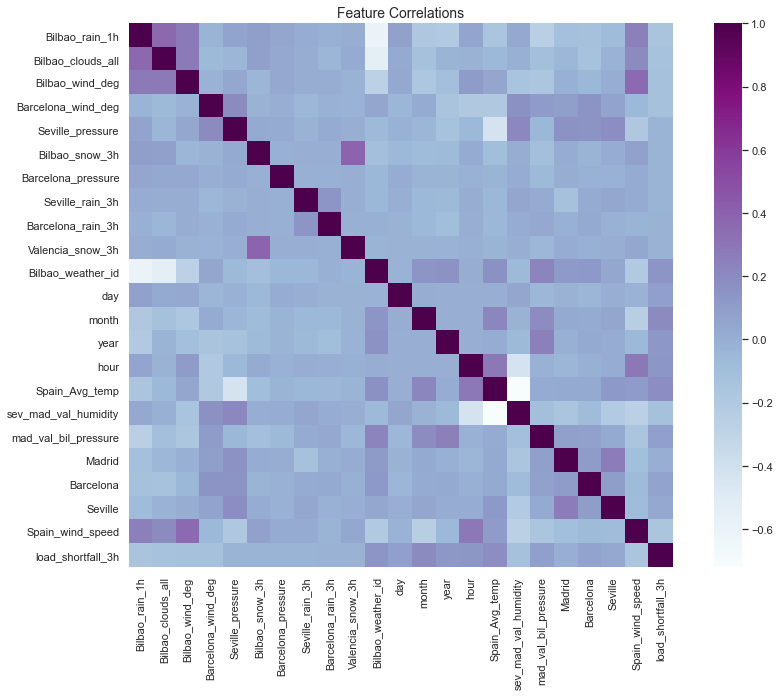

In [42]:
fig,axis = plt.subplots(figsize=(15, 10))
sns.heatmap(df_train.corr(), square=True, cmap='BuPu')
plt.title('Feature Correlations',fontsize=14)

plt.show()

In [26]:
df_train.head()

,Bilbao_rain_1h,Bilbao_clouds_all,Bilbao_wind_deg,Barcelona_wind_deg,Seville_pressure,Bilbao_snow_3h,Barcelona_pressure,Seville_rain_3h,Barcelona_rain_3h,Valencia_snow_3h,Bilbao_weather_id,day,month,year,hour,Spain_Avg_temp,sev_mad_val_humidity,mad_val_bil_pressure,Madrid,Barcelona,Seville,Spain_wind_speed,load_shortfall_3h
0,0.0,0.0,223.333333,42.666667,25.0,0.0,1036.333333,0.0,0.0,0.0,800.0,1,1,2015,3.0,272.086456,71.333333,1003.000000,266.666667,400.0,266.666667,2.400000,6715.666667
1,0.0,0.0,221.000000,139.000000,25.0,0.0,1037.333333,0.0,0.0,0.0,800.0,1,1,2015,6.0,272.799533,71.333333,1004.222222,266.666667,400.0,266.666667,2.066667,4171.666667
2,0.0,0.0,214.333333,326.000000,25.0,0.0,1038.000000,0.0,0.0,0.0,800.0,1,1,2015,9.0,277.224046,67.111111,1005.111111,266.666667,400.0,266.666667,1.533333,4274.666667
3,0.0,0.0,199.666667,273.000000,25.0,0.0,1037.000000,0.0,0.0,0.0,800.0,1,1,2015,12.0,283.351587,58.555556,1013.222222,266.666667,400.0,266.666667,1.866667,5075.666667
4,0.0,2.0,185.000000,260.000000,25.0,0.0,1035.000000,0.0,0.0,0.0,800.0,1,1,2015,15.0,283.134500,58.111111,1027.572691,266.666667,400.0,266.666667,1.933333,6620.666667


In [43]:
# re-arranging the columns so that the target column is the last one on the dataframe
new_cols=[item for item in df_train.columns if item != 'load_shortfall_3h'] +['load_shortfall_3h']

df_train = df_train[new_cols]

In [44]:
# Fit model using statsmodels.OLS
dfm = df_train.copy()
# Target variable:
y_name = 'load_shortfall_3h'
# All available features
X_names = [col for col in dfm.columns if col != y_name]
# Build OLS formula string " y ~ X "
formula_str = "dfm['" + y_name + "']" + " ~ "+" + ".join("dfm['{0}']".format(x) for x in X_names);
# Fit model using model dataframe
model=ols(formula=formula_str, data=dfm)
fitted = model.fit()
# Fitted summary
print(fitted.summary())

                               OLS Regression Results                               
Dep. Variable:     dfm['load_shortfall_3h']   R-squared:                       0.137
Model:                                  OLS   Adj. R-squared:                  0.135
Method:                       Least Squares   F-statistic:                     63.32
Date:                      Wed, 25 May 2022   Prob (F-statistic):          3.79e-260
Time:                              20:37:50   Log-Likelihood:                -86796.
No. Observations:                      8763   AIC:                         1.736e+05
Df Residuals:                          8740   BIC:                         1.738e+05
Df Model:                                22                                         
Covariance Type:                  nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------

In [29]:
# Recursive Feature Elimination
lgbm_model = lgbm.LGBMRegressor(learning_rate=0.1, min_data_in_leaf=250, num_leaves=50, objective='regression')
rfe = RFE(lgbm_model )
rfe = rfe.fit(X_train, y_train)

# Summarize the selected features
keep_df = pd.DataFrame(rfe.support_,X_train.columns).reset_index()
keep_df = keep_df[keep_df[0]==True]
keep_df = keep_df.drop(0,axis=1)
keep_df.rename(columns={'index':'Feature'}).style.hide_index()

[LightGBM] [Warning] min_data_in_leaf is set=250, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=250


Feature
Bilbao_wind_deg
Barcelona_wind_deg
Barcelona_pressure
day
month
year
hour
Spain_Avg_temp
sev_mad_val_humidity
mad_val_bil_pressure


In [45]:
df_train.head()

,Bilbao_rain_1h,Bilbao_clouds_all,Bilbao_wind_deg,Barcelona_wind_deg,Seville_pressure,Bilbao_snow_3h,Barcelona_pressure,Seville_rain_3h,Barcelona_rain_3h,Valencia_snow_3h,Bilbao_weather_id,day,month,year,hour,Spain_Avg_temp,sev_mad_val_humidity,mad_val_bil_pressure,Madrid,Barcelona,Seville,Spain_wind_speed,load_shortfall_3h
0,0.0,0.0,223.333333,42.666667,25.0,0.0,1036.333333,0.0,0.0,0.0,800.0,1,1,2015,3.0,272.086456,71.333333,1003.000000,266.666667,400.0,266.666667,2.400000,6715.666667
1,0.0,0.0,221.000000,139.000000,25.0,0.0,1037.333333,0.0,0.0,0.0,800.0,1,1,2015,6.0,272.799533,71.333333,1004.222222,266.666667,400.0,266.666667,2.066667,4171.666667
2,0.0,0.0,214.333333,326.000000,25.0,0.0,1038.000000,0.0,0.0,0.0,800.0,1,1,2015,9.0,277.224046,67.111111,1005.111111,266.666667,400.0,266.666667,1.533333,4274.666667
3,0.0,0.0,199.666667,273.000000,25.0,0.0,1037.000000,0.0,0.0,0.0,800.0,1,1,2015,12.0,283.351587,58.555556,1013.222222,266.666667,400.0,266.666667,1.866667,5075.666667
4,0.0,2.0,185.000000,260.000000,25.0,0.0,1035.000000,0.0,0.0,0.0,800.0,1,1,2015,15.0,283.134500,58.111111,1027.572691,266.666667,400.0,266.666667,1.933333,6620.666667


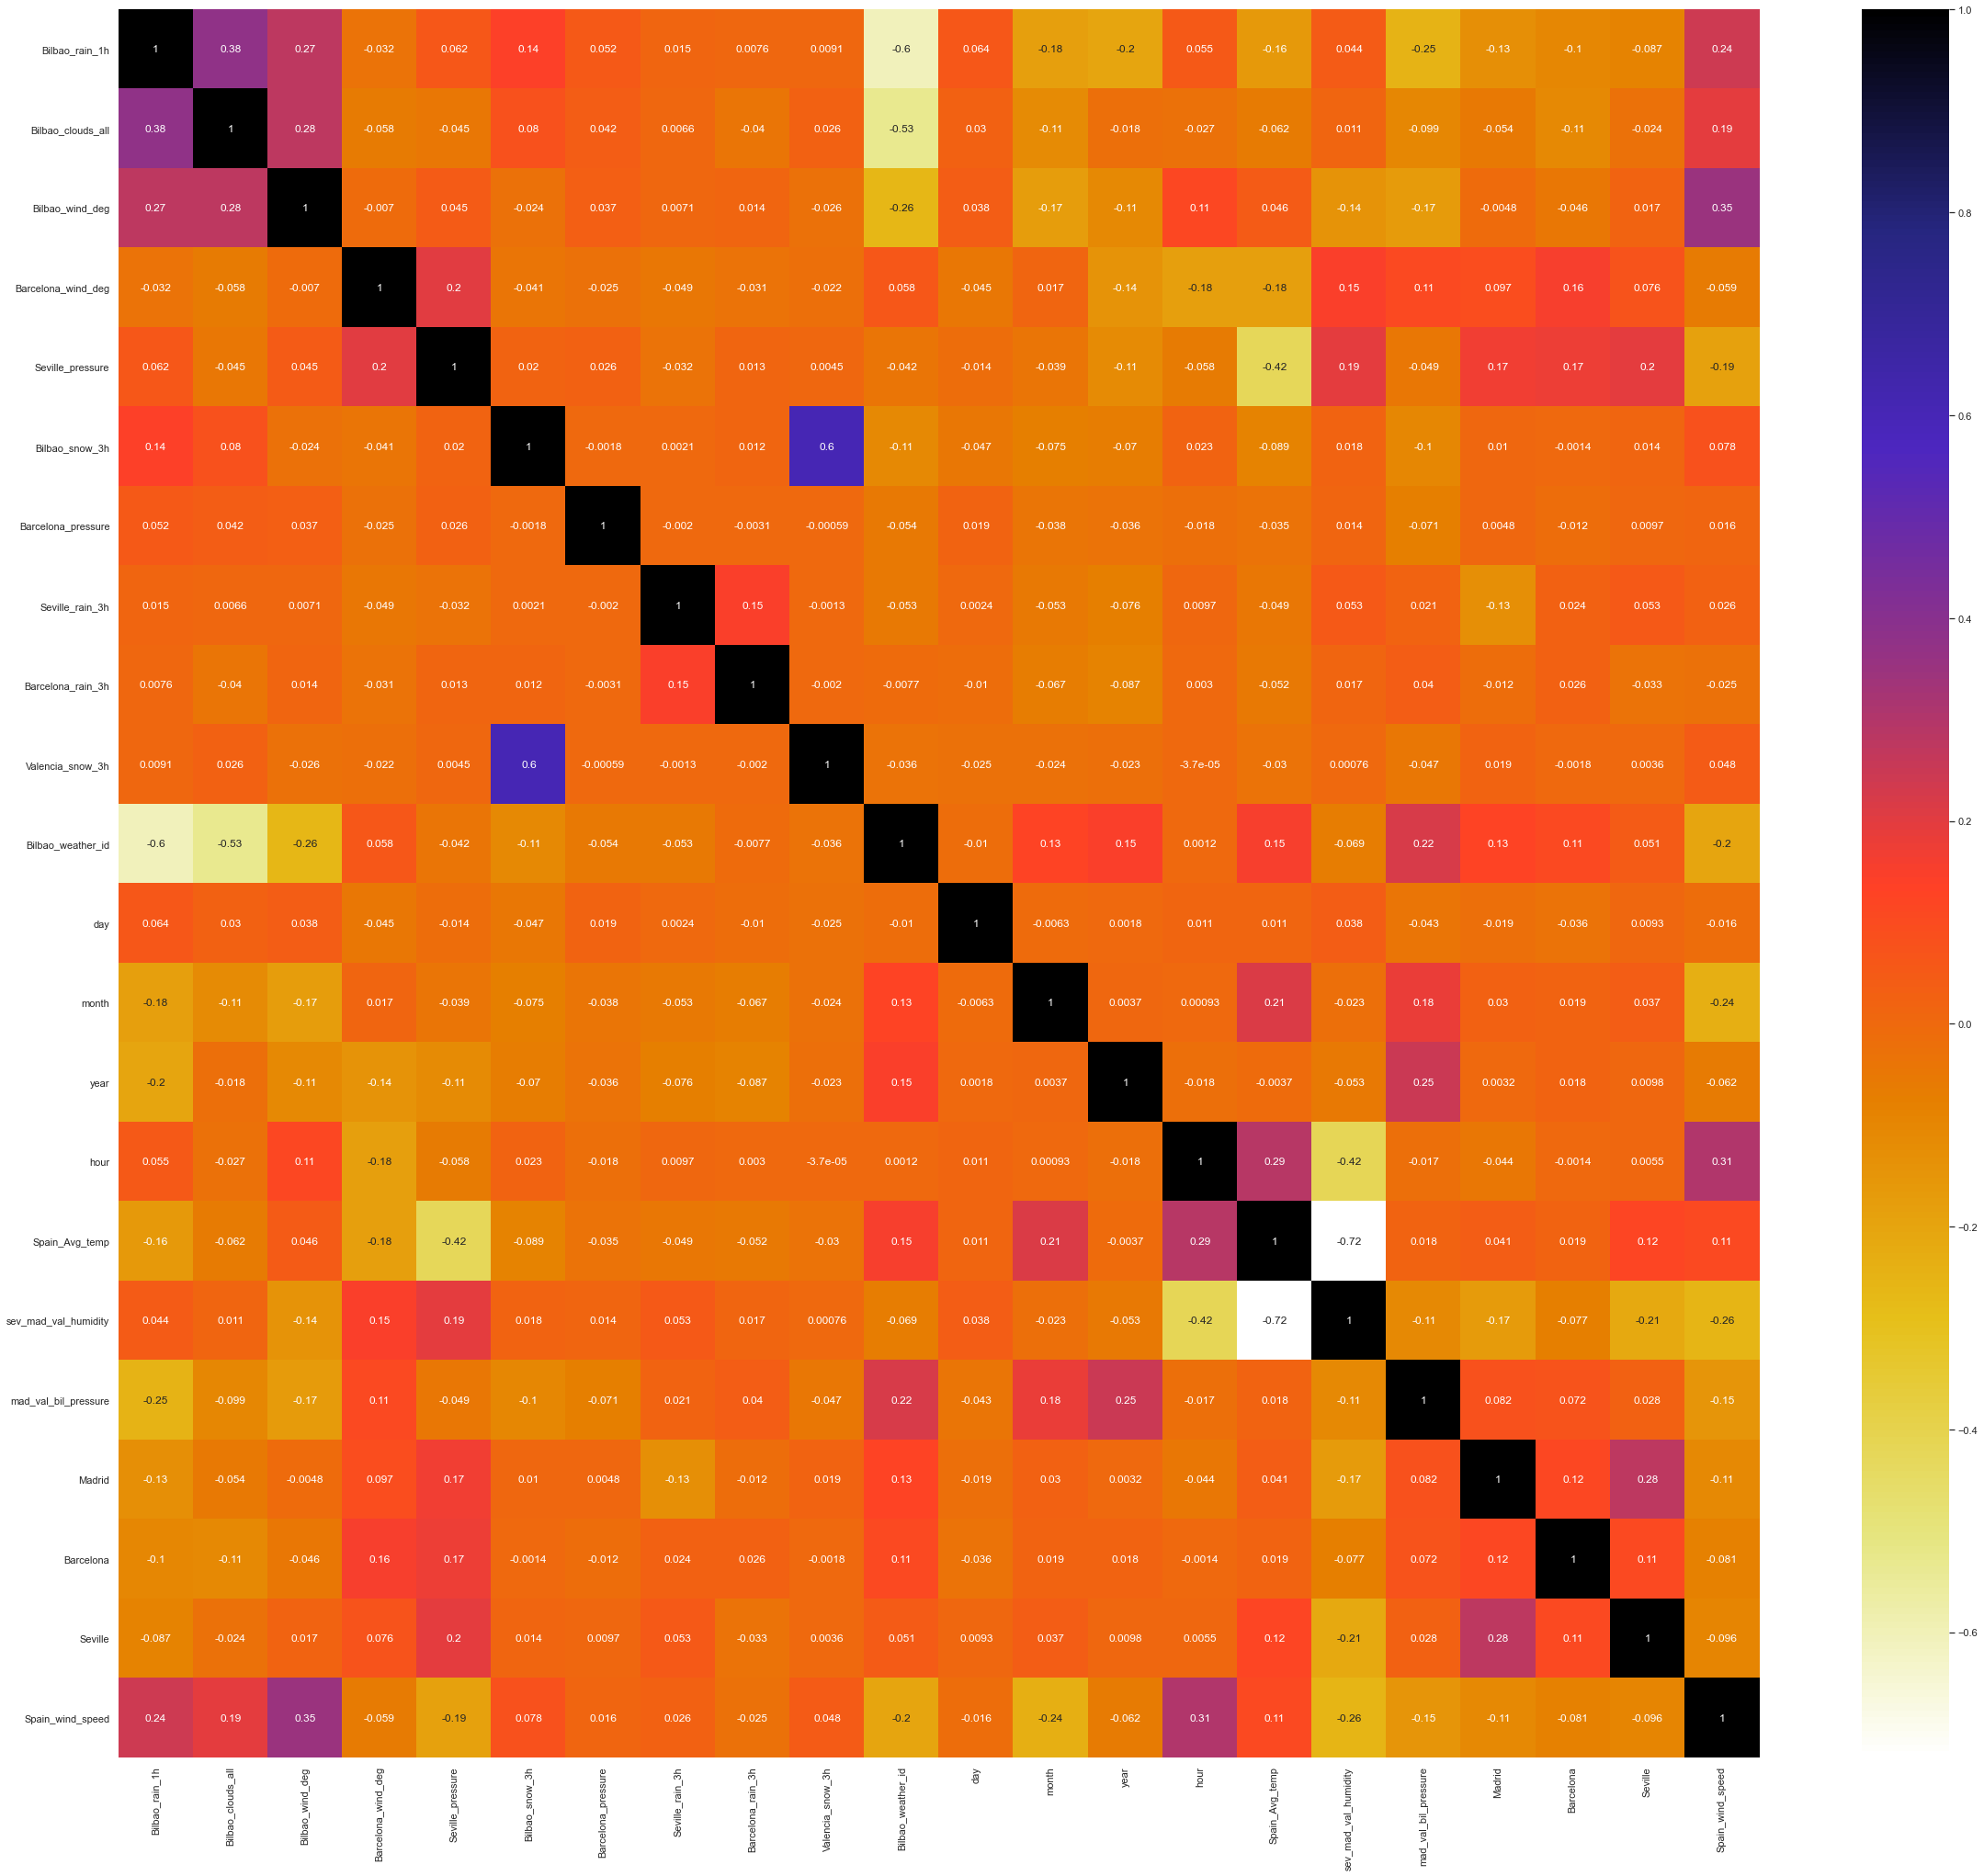

In [30]:
#Using Pearson Correlation
plt.figure(figsize=(40,35))
cor = X_train.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.CMRmap_r)
plt.show()

In [47]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.3,
    random_state=0)


### Linear Regression

In [53]:
modelstart= time.time()
lm = LinearRegression()
lm.fit(X_train.iloc[:,3].to_frame(), y_train)
y_pred_lm = lm.predict(X_test.iloc[:,3].to_frame())
lm_rmse = sqrt(metrics.mean_squared_error(y_test, y_pred_lm))
lm_r2 = metrics.r2_score(y_test, y_pred_lm)

print("Testing: Linear Regression")
print('RMSE:', lm_rmse)
print('R-squared:', lm_r2)
print("Model Runtime: %0.2f seconds"%((time.time() - modelstart)))

Testing: Linear Regression
RMSE: 5213.462254426731
R-squared: 0.01696694392348519
Model Runtime: 0.00 seconds


In [54]:
modelstart= time.time()
lm = LinearRegression()
lm.fit(X_train.iloc[:,3].to_frame(), y_train)
y_pred_lm = lm.predict(X_test.iloc[:,3].to_frame())
lm_rmse = sqrt(metrics.mean_squared_error(y_test, y_pred_lm))
lm_r2 = metrics.r2_score(y_test, y_pred_lm)

print("Testing: Linear Regression")
print('RMSE:', lm_rmse)
print('R-squared:', lm_r2)
print("Model Runtime: %0.2f seconds"%((time.time() - modelstart)))

Testing: Linear Regression
RMSE: 5213.462254426731
R-squared: 0.01696694392348519
Model Runtime: 0.01 seconds


### Multiple Linear Regression

In [55]:
modelstart= time.time()
ml = LinearRegression()
ml.fit(X_train, y_train)
y_pred_ml = ml.predict(X_test)
ml_rmse = sqrt(metrics.mean_squared_error(y_test, y_pred_ml))
ml_r2 = metrics.r2_score(y_test, y_pred_ml)

print("Testing: Multiple Linear Regression")
print('RMSE:', ml_rmse)
print('R-squared:', ml_r2)
print("Model Runtime: %0.2f seconds"%((time.time() - modelstart)))

Testing: Multiple Linear Regression
RMSE: 4898.972345297886
R-squared: 0.13198819728410538
Model Runtime: 0.72 seconds


### Polynomial Regression

In [56]:
modelstart= time.time()
poly_reg = PolynomialFeatures(degree = 2)
X_poly = poly_reg.fit_transform(X_train)
regressor = LinearRegression()
regressor.fit(X_poly, y_train)
y_pred_poly = regressor.predict(poly_reg.transform(X_test))
pl_rmse = sqrt(metrics.mean_squared_error(y_test, y_pred_poly))
pl_r2 = metrics.r2_score(y_test, y_pred_poly)

print("Testing: Polynomial Regression")
print('RMSE:', pl_rmse)
print('R-squared:', pl_r2)
print("Model Runtime: %0.2f seconds"%((time.time() - modelstart)))

Testing: Polynomial Regression
RMSE: 72305.76300125396
R-squared: -188.0869172428602
Model Runtime: 0.56 seconds


### Ridge Regression

In [57]:
modelstart= time.time()
ridge = Ridge(alpha =0.01)
ridge.fit(X_train, y_train)
y_pred = ridge.predict(X_test)
rd_rmse = sqrt(metrics.mean_squared_error(y_test, y_pred))
rd_r2 = metrics.r2_score(y_test, y_pred)

print("Testing: Ridge Regression")
print('RMSE:', rd_rmse)
print('R-squared:', rd_r2)
print("Model Runtime: %0.2f seconds"%((time.time() - modelstart)))

Testing: Ridge Regression
RMSE: 4898.68008566678
R-squared: 0.1320917607354979
Model Runtime: 0.48 seconds


### CatBoost Regression

In [58]:
modelstart= time.time()
cb_model = CatBoostRegressor(iterations=900,
                             learning_rate=0.02,
                             depth=12,
                             eval_metric='RMSE',
                             random_seed = 0,
                             bagging_temperature = 0.2,
                             od_type='Iter',
                             metric_period = 65,
                             od_wait=100)
cb_model.fit(X_train, y_train, eval_set=(X_test,y_test), use_best_model=True,verbose=True)
y_pred_val = cb_model.predict(X_test)
cb_model_rmse = sqrt(metrics.mean_squared_error(y_test, y_pred_val))
cb_model_r2 = metrics.r2_score(y_test, y_pred_val)
print('RMSE:', cb_model_rmse)
print('R-squared:', cb_model_r2)
print("Model Runtime: %0.2f seconds"%((time.time() - modelstart)))

0:	learn: 5157.7046960	test: 5226.1097026	best: 5226.1097026 (0)	total: 829ms	remaining: 12m 25s
65:	learn: 3642.7291254	test: 4016.4340279	best: 4016.4340279 (65)	total: 17.9s	remaining: 3m 45s
130:	learn: 3055.7408391	test: 3664.9621855	best: 3664.9621855 (130)	total: 34.9s	remaining: 3m 24s
195:	learn: 2717.7865790	test: 3508.5418587	best: 3508.5418587 (195)	total: 52s	remaining: 3m 6s
260:	learn: 2459.5060422	test: 3399.5526511	best: 3399.5526511 (260)	total: 1m 9s	remaining: 2m 49s
325:	learn: 2249.7967974	test: 3323.4307952	best: 3323.4307952 (325)	total: 1m 25s	remaining: 2m 31s
390:	learn: 2076.1818119	test: 3265.9283098	best: 3265.9283098 (390)	total: 1m 42s	remaining: 2m 13s
455:	learn: 1914.0967592	test: 3217.8969813	best: 3217.8969813 (455)	total: 2m	remaining: 1m 56s
520:	learn: 1765.9480905	test: 3168.3194055	best: 3168.3194055 (520)	total: 2m 17s	remaining: 1m 39s
585:	learn: 1641.8248807	test: 3126.9830234	best: 3126.9830234 (585)	total: 2m 34s	remaining: 1m 22s
650:	le

### Random Forest Regression

In [59]:
modelstart= time.time()
rf = RandomForestRegressor(random_state = 0, n_estimators= 300)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
rf_rmse = sqrt(metrics.mean_squared_error(y_test, y_pred))
rf_r2 = metrics.r2_score(y_test, y_pred)

print("Testing: Random Forest Regression")
print('RMSE:', rf_rmse)
print('R-squared:', rf_r2)
print("Model Runtime: %0.2f seconds"%((time.time() - modelstart)))

Testing: Random Forest Regression
RMSE: 3111.2434907812594
R-squared: 0.6499068149988925
Model Runtime: 23.56 seconds


### eXtreme Gradient Boosting regression

In [60]:
modelstart= time.time()
xg_reg = xgb.XGBRegressor()
xg_reg.fit(X_train,y_train)
y_pred = xg_reg.predict(X_test)
xg_rmse = sqrt(metrics.mean_squared_error(y_test, y_pred))
xg_r2 = metrics.r2_score(y_test, y_pred)

print("Testing: XGBoost")
print('RMSE:', xg_rmse)
print('R-squared:', xg_r2)
print("Model Runtime: %0.2f seconds"%((time.time() - modelstart)))

Testing: XGBoost
RMSE: 3062.660070517115
R-squared: 0.6607551623394323
Model Runtime: 1.67 seconds


### Lasso Regression

In [61]:
modelstart= time.time()
lasso = Lasso(alpha =0.01)
lasso.fit(X_train, y_train)
y_pred = lasso.predict(X_test)
ls_rmse = sqrt(metrics.mean_squared_error(y_test, y_pred))
ls_r2 = metrics.r2_score(y_test, y_pred)

print("Testing: Lasso Regression")
print('RMSE:', ls_rmse)
print('R-squared:', ls_r2)
print("Model Runtime: %0.2f seconds"%((time.time() - modelstart)))

Testing: Lasso Regression
RMSE: 4898.827416840437
R-squared: 0.13203955407567558
Model Runtime: 0.22 seconds


### Light Gradient Boosting Machine

In [62]:
modelstart= time.time()
lgbm_model = lgbm.LGBMRegressor(learning_rate=0.1, min_data_in_leaf=250, num_leaves=50, objective='regression')
lgbm_model.fit(X_train,y_train)
y_pred = lgbm_model.predict(X_test)
lgbm_rmse = sqrt(metrics.mean_squared_error(y_test, y_pred))
lgbm_r2 = metrics.r2_score(y_test, y_pred)

print("Testing: LightGBM")
print('RMSE:', lgbm_rmse)
print('R-squared:', lgbm_r2)
print("Model Runtime: %0.2f seconds"%((time.time() - modelstart)))

[LightGBM] [Warning] min_data_in_leaf is set=250, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=250
Testing: LightGBM
RMSE: 3421.739112903521
R-squared: 0.5765428765806571
Model Runtime: 0.50 seconds


<a id="six"></a>
## 6. Model Performance

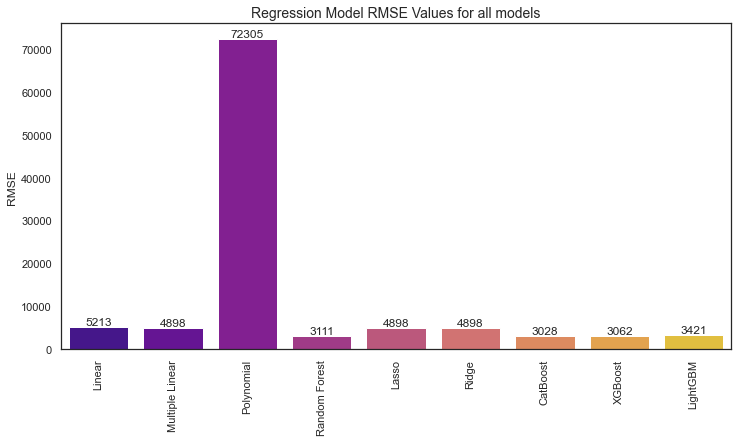

In [63]:
# Compare RMSE values between models
fig,axis = plt.subplots(figsize=(12, 6))
rmse_x = ['Linear','Multiple Linear','Polynomial','Random Forest','Lasso','Ridge','CatBoost','XGBoost','LightGBM']
rmse_y = [lm_rmse,ml_rmse,pl_rmse,rf_rmse,ls_rmse,rd_rmse,cb_model_rmse,xg_rmse,lgbm_rmse]
ax = sns.barplot(x=rmse_x, y=rmse_y,palette='plasma')
plt.title('Regression Model RMSE Values for all models',fontsize=14)
plt.ylabel('RMSE')
plt.xticks(rotation=90)
for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2., p.get_height(), '%d' % int(p.get_height()), fontsize=12, ha='center', va='bottom')

plt.show()

In [66]:
df_test.head()

,time,Bilbao_rain_1h,Bilbao_clouds_all,Bilbao_wind_deg,Barcelona_wind_deg,Seville_pressure,Bilbao_snow_3h,Barcelona_pressure,Seville_rain_3h,Barcelona_rain_3h,Valencia_snow_3h,Bilbao_weather_id,day,month,year,hour,Spain_Avg_temp,sev_mad_val_humidity,mad_val_bil_pressure,Madrid,Barcelona,Seville,Spain_wind_speed
0,2018-01-01 00:00:00,0.0,20.000000,193.333333,176.666667,25.0,0,1017.333333,0.0,0.0,0,801.000000,1,1,2018,0.0,283.817333,68.222222,1022.938339,266.666667,400.000000,266.666667,3.600000
1,2018-01-01 03:00:00,0.0,0.000000,143.333333,266.666667,25.0,0,1020.333333,0.0,0.0,0,721.000000,1,1,2018,3.0,282.070000,73.555556,1023.382784,266.666667,400.166667,266.666667,3.800000
2,2018-01-01 06:00:00,0.0,0.000000,130.000000,263.333333,25.0,0,1023.000000,0.0,0.0,0,800.000000,1,1,2018,6.0,280.463333,73.555556,1023.049450,266.666667,400.000000,269.000000,2.866667
3,2018-01-01 09:00:00,0.0,26.666667,196.666667,86.666667,25.0,0,1025.666667,0.0,0.0,0,801.333333,1,1,2018,9.0,280.875778,73.666667,1023.493895,266.666667,400.000000,269.000000,3.466667
4,2018-01-01 12:00:00,0.0,26.666667,233.333333,283.333333,25.0,0,1026.000000,0.0,0.0,0,801.333333,1,1,2018,12.0,284.922667,56.777778,1022.605006,266.666667,400.166667,266.666667,5.800000


In [64]:
time_df = df_test.copy()

In [67]:
results = pd.DataFrame({})

In [68]:
results['time'] = time_df['time']
df_test.drop('time', axis =1, inplace = True)


In [77]:
results['load_shortfall_3h'] = lgbm_model.predict(df_test)

In [78]:
results.to_csv('Results_lgbm.csv', index = False) # write results to csv file

<a id="seven"></a>
## 7. Model Explanations

In [74]:
results.head()

,time,load_shortfall_3h
0,2018-01-01 00:00:00,11563.889250
1,2018-01-01 03:00:00,8748.878674
2,2018-01-01 06:00:00,7255.597391
3,2018-01-01 09:00:00,9950.427079
4,2018-01-01 12:00:00,10438.418816
